## Psychological Stress Classification Using Natural Language Processing & Deep Learning (Ablation Studies)

### Abhay Puri & Sara Besharati



## Initialisation 

### Imports

In [ ]:
import torch
torch.cuda.empty_cache()
CUDA_LAUNCH_BLOCKING=1

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fastText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import pandas as pd
import numpy as np
import os
import string 
import tqdm
import warnings
import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import re

from gensim.models import LdaModel
from gensim import models, corpora, similarities
import gensim
from gensim.utils import simple_preprocess

from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional
from tensorflow.keras.layers import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.utils import pad_sequences
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction import text

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import fasttext.util



In [ ]:
# ------------ https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [ ]:
#Another way to check if GPU is available or not and print the name of the GPU
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("Using CPU")


Using GPU: Tesla T4


### Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Abhay/Stress_Analysis_in_Social_Media

/content/drive/MyDrive/Abhay/Stress_Analysis_in_Social_Media


In [ ]:
train = pd.read_csv('dreaddit-train.csv')
test = pd.read_csv('dreaddit-test.csv')

In [ ]:
# Drop the columns post_id and id, sentence_range
train = train.drop(['post_id', 'id', 'sentence_range'], axis=1)
test = test.drop(['post_id', 'id', 'sentence_range'], axis=1)

## Preprocessing

In [ ]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
# Clean the text by removing stopwords , expanding contractions, and lemmatizing
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert words to lower case and split them
    text = text.lower().split()
    # Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    # Expand contractions
    if text in contractions:
        return contractions[text]
    else:
        return text

In [ ]:
# Normalize text by replacing ips, urls, and usernames with a placeholder, punctuation with spaces, and removing extra spaces, some special characters , replace number and symbols with language words e.g. 2 -> two, & -> and
def normalize_text(text):
    # Replace ips with placeholder
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', 'ip', text)
    # Replace urls with placeholder
    text = re.sub(r'http\S+', 'url', text)
    # Replace usernames with placeholder
    text = re.sub(r'@\S+', 'user', text)
    # Replace punctuation with spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Change numbers to words 
    num2words = {0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}
    # Replace numbers with language words
    text = re.sub(r'\d+', num2words, text)
    # Replace symbols with language words
    text = re.sub(r'&', 'and', text)
    text = re.sub(r'@', 'at', text)
    text = re.sub(r'!', 'exclamation', text)
    text = re.sub(r'\$', 'dollar', text)
    text = re.sub(r'%', 'percent', text)
    return text



In [ ]:
def text_preprocessing(s):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """

    # Remove entity mentions
    s = re.sub(r'@\S+', '', s)

    # Correct errors
    s = re.sub(r'&amp;', '&', s)
    s = re.sub(r'&gt;', '>', s)
    s = re.sub(r'&lt;', '<', s)
    s = re.sub(r'&quot;', '"', s)
    s = re.sub(r'&apos;', "'", s)

    # Lowercase the sentence
    s = s.lower()

    # Change "'t" to "not"
    s = re.sub(r"\'t", " not", s)

    # Remove "@name"
    s = re.sub(r'@\S+', '', s)

    # Isolate and remove punctuations except "?"
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)

    # Remove other special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)

    # Remove stop words except "not" and "can"
    s = ' '.join([word for word in s.split() if word not in stopwords.words('english') or word in ['not', 'can']])

    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [ ]:
train.head()

,Unnamed: 0,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,1,ptsd,"He said he had not felt that way before, sugge...",1,0.8,1521614353,5,1.806818,116,72.64,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,2,assistance,"Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,4,9.429737,109,79.08,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,3,ptsd,My mom then hit me with the newspaper and it s...,1,0.8,1535935605,2,7.769821,167,33.80,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,4,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,0,2.667798,273,2.98,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,5,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,0.8,1539809005,24,7.554238,89,32.22,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [ ]:
train['clean'] = train['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
test['clean'] = test['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

train['preprocess'] = train['text'].apply(lambda x: text_preprocessing(x))
test['preprocess'] = test['text'].apply(lambda x: text_preprocessing(x))

train['final_clean'] = train['text'].apply(lambda x: clean_text(x))
test['final_clean'] = test['text'].apply(lambda x: clean_text(x))
     

In [ ]:
train.head()

,Unnamed: 0,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,...,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,clean,preprocess,final_clean
0,1,ptsd,"He said he had not felt that way before, sugge...",1,0.8,1521614353,5,1.806818,116,72.64,...,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,"[he, said, he, had, not, felt, that, way, befo...",said not felt way suggeted go rest trigger ahe...,said felt way suggeted rest trigger ahead youi...
1,2,assistance,"Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,4,9.429737,109,79.08,...,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,"[hey, there, assistance, not, sure, if, this, ...",hey r assistance not sure right place post goe...,hey rassistance sure right place post goes cur...
2,3,ptsd,My mom then hit me with the newspaper and it s...,1,0.8,1535935605,2,7.769821,167,33.80,...,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894,"[my, mom, then, hit, me, with, the, newspaper,...",mom hit newspaper shocked would knows not like...,mom hit newspaper shocked would knows dont lik...
3,4,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,0,2.667798,273,2.98,...,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671,"[until, met, my, new, boyfriend, he, is, amazi...",met new boyfriend amazing kind sweet good stud...,met new boyfriend amazing kind sweet good stud...
4,5,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,0.8,1539809005,24,7.554238,89,32.22,...,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167,"[october, is, domestic, violence, awareness, m...",october domestic violence awareness month dome...,october domestic violence awareness month dome...


## Feature engineering

In [ ]:
%pip install pyspellchecker
%pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Another way to count the number of punctuations
def punctuations(text):
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  count = 0
  for i in text:
    if i in punctuations:
      count +=1
  return count/(len(text))


<>:3: DeprecationWarning: invalid escape sequence \,
<>:3: DeprecationWarning: invalid escape sequence \,
<ipython-input-71-1343277204a0>:3: DeprecationWarning: invalid escape sequence \,
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''


In [ ]:
# Apply punctuation count to the train and test data
train['punctuation_count'] = train['text'].apply(lambda x: punctuations(x))
test['punctuation_count'] = test['text'].apply(lambda x: punctuations(x))


## LDA

In [ ]:
def words(sentences):
    s = []
    for sent in sentences:
        s.append(text_preprocessing(sent))
    return s

def stopwords_removal(texts):
    # Return stopwords in english from texts
    for word in stopwords.words('english'):
        token = " " + word + " "
        texts = str(texts).replace(token, " ")
        texts = texts.replace(" ", " ")
    return texts

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def data(df):
    # Convert sentences to words
    conversion_words = list(words(df['preprocess'].str.strip()))
    # Remove stopwords
    conversion_words = stopwords_removal(conversion_words)
    # Create bigrams
    bigram = bigrams(conversion_words)
    bigram = [bigram[s] for s in conversion_words]
    # Create dictionary to map words to ids
    id = gensim.corpora.Dictionary(bigram)
    id.filter_extremes(no_below=10, no_above=0.35)
    id.compactify()
    # Create corpus
    data = []
    for i in range(len(bigram)):
        data.append(id.doc2bow(bigram[i]))
    return data, id, bigram
    

In [ ]:
stop_words = stopwords.words('english')
train_corpus, train_id2word, bigram_train = data(train)
test_corpus, test_id2word, bigram_test = data(test)

In [ ]:
# Training the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                             id2word=train_id2word,
                                                num_topics=10,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

# Print the Keyword in the 10 topics
print(lda_model.print_topics())


In [ ]:
import pyLDAvis.gensim_models
visualize_lda = pyLDAvis.gensim_models.prepare(lda_model, train_corpus, train_id2word, sort_topics=False)
pyLDAvis.display(visualize_lda)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
def bigram_data(df):
    """
    For the test data we only need the bigram data. This is a requirement due to 
    the shapes Gensim functions expect in the test-vector transformation below.
    With both these in hand, we can make the test corpus.
    """
    # Convert sentences to words
    conversion_words = list(words(df['preprocess'].str.strip()))
    # Remove stopwords
    conversion_words = stopwords_removal(conversion_words)
    # Create bigrams
    bigram = bigrams(conversion_words)
    bigram = [bigram[s] for s in conversion_words]
    return bigram

bigram_res = bigram_data(test)
test_corpus = [train_id2word.doc2bow(text) for text in bigram_test]



## Word2Vec embedding

In [ ]:
# Divide the data
X_train, X_test, y_train, y_test = train_test_split(train['preprocess'], train['label'], test_size=0.2, random_state=42)

# Train word2vec model
model1 = gensim.models.Word2Vec(
        X_train,
        size=150, # Dimensionality of the word vectors
        window=10, # Maximum distance between the current and predicted word within a sentence
        min_count=2, # Ignores all words with total frequency lower than this
        workers=10, # Number of processors (parallelisation)
        sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW
        iter=100) # Number of epochs

# Get the word vectors
w2v = dict(zip(model1.wv.index2word, model1.wv.syn0))

# Next we need to create a tokenizer object
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequence of tokens and pad them to ensure equal length vectors
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 150))

for word, i in tokenizer.word_index.items():
    if word in w2v:
        embedding_matrix[i] = w2v[word]

# Create the model
model1 = Sequential()
model1.add(Embedding(vocab_size, 150, weights=[embedding_matrix], input_length=100, trainable=False))
model1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
print(model1.summary())




<ipython-input-100-6ad589ed8884>:15: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  w2v = dict(zip(model1.wv.index2word, model1.wv.syn0))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 150)          1537500   
                                                                 
 lstm_7 (LSTM)               (None, 100)               100400    
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,638,001
Trainable params: 100,501
Non-trainable params: 1,537,500
_________________________________________________________________
None


Epoch 1/10
18/18 - 10s - loss: 0.6886 - accuracy: 0.5370 - val_loss: 0.6875 - val_accuracy: 0.5528 - 10s/epoch - 550ms/step
Epoch 2/10
18/18 - 8s - loss: 0.6879 - accuracy: 0.5414 - val_loss: 0.6880 - val_accuracy: 0.5563 - 8s/epoch - 450ms/step
Epoch 3/10
18/18 - 7s - loss: 0.6873 - accuracy: 0.5449 - val_loss: 0.6869 - val_accuracy: 0.5581 - 7s/epoch - 366ms/step
Epoch 4/10
18/18 - 7s - loss: 0.6866 - accuracy: 0.5419 - val_loss: 0.6866 - val_accuracy: 0.5616 - 7s/epoch - 363ms/step
Epoch 5/10
18/18 - 6s - loss: 0.6864 - accuracy: 0.5463 - val_loss: 0.6876 - val_accuracy: 0.5581 - 6s/epoch - 359ms/step
Epoch 6/10
18/18 - 6s - loss: 0.6863 - accuracy: 0.5502 - val_loss: 0.6870 - val_accuracy: 0.5475 - 6s/epoch - 357ms/step
Epoch 7/10
18/18 - 7s - loss: 0.6853 - accuracy: 0.5511 - val_loss: 0.6886 - val_accuracy: 0.5511 - 7s/epoch - 361ms/step
Epoch 8/10
18/18 - 7s - loss: 0.6857 - accuracy: 0.5480 - val_loss: 0.6880 - val_accuracy: 0.5599 - 7s/epoch - 374ms/step
Epoch 9/10
18/18 - 7s 

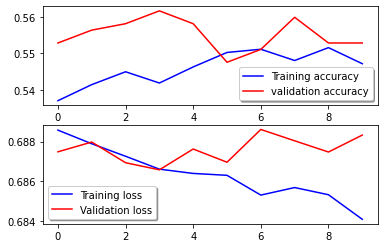

In [ ]:
# Fit the model
history = model1.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), verbose=2)

# Plot the accuracy and loss curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r', label="validation accuracy",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r',label="Validation loss")
legend = ax[1].legend(loc='best', shadow=True)


In [ ]:
# Predict the labels of the test set
y_pred = model1.predict(X_test).ravel()

18/18 [==============================] - 1s 49ms/step


In [ ]:
from sklearn.metrics import accuracy_score,f1_score
accuracy = accuracy_score(y_test, np.round(y_pred))
f1 = f1_score(y_test,np.round(y_pred))


In [ ]:
accuracy

0.5528169014084507

In [ ]:
f1

0.684863523573201

## gloVe embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-04 17:39:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-04 17:39:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-04 17:39:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# Divide the data into train and test sets to implement glove model
X_train, X_test, y_train, y_test = train_test_split(train['preprocess'], train['label'], test_size=0.2, random_state=42)

# Implement glove model
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequence of tokens and pad them to ensure equal length vectors
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the model
model2 = Sequential()
model2.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
print(model2.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          1025000   
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,105,501
Trainable params: 80,501
Non-trainable params: 1,025,000
_________________________________________________________________
None


Epoch 1/10
18/18 - 11s - loss: 0.6734 - accuracy: 0.5789 - val_loss: 0.6596 - val_accuracy: 0.6039 - 11s/epoch - 601ms/step
Epoch 2/10
18/18 - 7s - loss: 0.6120 - accuracy: 0.6502 - val_loss: 0.5801 - val_accuracy: 0.7025 - 7s/epoch - 373ms/step
Epoch 3/10
18/18 - 7s - loss: 0.5513 - accuracy: 0.7137 - val_loss: 0.5548 - val_accuracy: 0.7271 - 7s/epoch - 372ms/step
Epoch 4/10
18/18 - 8s - loss: 0.5274 - accuracy: 0.7291 - val_loss: 0.5798 - val_accuracy: 0.6989 - 8s/epoch - 443ms/step
Epoch 5/10
18/18 - 9s - loss: 0.5170 - accuracy: 0.7401 - val_loss: 0.5435 - val_accuracy: 0.7342 - 9s/epoch - 506ms/step
Epoch 6/10
18/18 - 7s - loss: 0.5096 - accuracy: 0.7454 - val_loss: 0.5743 - val_accuracy: 0.6972 - 7s/epoch - 371ms/step
Epoch 7/10
18/18 - 7s - loss: 0.4974 - accuracy: 0.7586 - val_loss: 0.5514 - val_accuracy: 0.7377 - 7s/epoch - 379ms/step
Epoch 8/10
18/18 - 7s - loss: 0.4775 - accuracy: 0.7590 - val_loss: 0.5419 - val_accuracy: 0.7394 - 7s/epoch - 363ms/step
Epoch 9/10
18/18 - 7s 

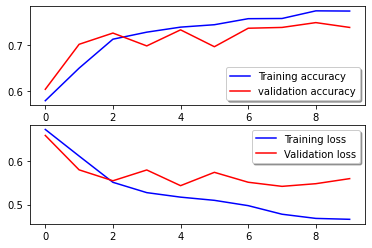

In [ ]:
# Fit the model
history = model2.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), verbose=2)

# Plot the accuracy and loss curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r', label="validation accuracy",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r',label="Validation loss")

legend = ax[1].legend(loc='best', shadow=True)



In [ ]:
# Predict the labels of the test set
y_pred = model2.predict(X_test)

y_pred

18/18 [==============================] - 1s 52ms/step


array([[0.20229322],
       [0.63100356],
       [0.7522151 ],
       [0.78997695],
       [0.09162158],
       [0.06291508],
       [0.60931575],
       [0.11261878],
       [0.46286282],
       [0.00776357],
       [0.90555334],
       [0.74835926],
       [0.47561055],
       [0.92671454],
       [0.3925403 ],
       [0.6448441 ],
       [0.31744033],
       [0.8438067 ],
       [0.9598234 ],
       [0.10467904],
       [0.6863177 ],
       [0.7668219 ],
       [0.28178343],
       [0.926357  ],
       [0.09713367],
       [0.71304995],
       [0.91329837],
       [0.567573  ],
       [0.35750118],
       [0.44505402],
       [0.27422363],
       [0.06238909],
       [0.76683015],
       [0.77398956],
       [0.5633828 ],
       [0.5436457 ],
       [0.3766273 ],
       [0.85957587],
       [0.73387486],
       [0.9079373 ],
       [0.95262706],
       [0.40768126],
       [0.9183589 ],
       [0.01568658],
       [0.8686564 ],
       [0.79921633],
       [0.9067878 ],
       [0.875

In [ ]:
accuracy = accuracy_score(y_test, np.round(y_pred))

In [ ]:
accuracy

0.7394366197183099

## FastText

In [ ]:
# Download the model from fasttext in english
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

# Unzip the file
!gunzip cc.en.300.vec.gz

--2022-12-04 17:51:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  21.0MB/s    in 68s     

2022-12-04 17:52:55 (18.5 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
# Divide the data into train and test sets for fasttext model
X_train, X_test, y_train, y_test = train_test_split(train['preprocess'], train['label'], test_size=0.2, random_state=42)

# Tokenize the sentences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Convert the sentences to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

# Load the fasttext model
embeddings_index = {}
f = open('cc.en.300.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()


In [ ]:
# Create the embedding matrix
embedding_matrix = np.zeros((5000+1, 300))
for word, i in tokenizer.word_index.items():
    if i > 5000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the model
model3 = Sequential()
model3.add(Embedding(5000+1, 300, weights=[embedding_matrix], input_length=100, trainable=False))
model3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit the model
history3 = model3.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Predict the labels of the test set
y_pred = model3.predict(X_test)

# import accuracy_score
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy_score(y_test, np.round(y_pred))

Epoch 1/5
36/36 [==============================] - 16s 449ms/step - loss: 0.4709 - accuracy: 0.7758 - val_loss: 0.5540 - val_accuracy: 0.7412
Epoch 2/5
36/36 [==============================] - 14s 395ms/step - loss: 0.4575 - accuracy: 0.7780 - val_loss: 0.5349 - val_accuracy: 0.7254
Epoch 3/5
36/36 [==============================] - 14s 382ms/step - loss: 0.4404 - accuracy: 0.7921 - val_loss: 0.5276 - val_accuracy: 0.7465
Epoch 4/5
36/36 [==============================] - 14s 404ms/step - loss: 0.4357 - accuracy: 0.7982 - val_loss: 0.5345 - val_accuracy: 0.7324
Epoch 5/5
18/18 [==============================] - 0s 27ms/step


0.670774647887324